In [1]:
%precision 3

import numpy as np
import pandas as pd
from dtw import *
from matplotlib import pyplot as plt
from matplotlib import ticker
plt.style.use("minimal")

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [58]:
session = 4
datafile_path = f"data/Test{session}.tsv"

metadata_header_lines = 9

events = pd.read_csv(datafile_path, sep = "\t", header = None, names = ("Type", "Name", "Frame", "Time"), skiprows=metadata_header_lines, on_bad_lines = "skip").drop(columns = ["Type"])

amount_trials = 1 + len(events[events["Name"] == "Trial"])
print(f"""[INFO] found {amount_trials} trial{"s" if amount_trials > 1 else ""}""")

marker_names = pd.read_csv(datafile_path, sep = "\t", header = None, skiprows=metadata_header_lines + len(events), nrows = 1).loc[0, 1:].values
markers = list(sorted(set([name[2:] for name in marker_names])))
print(f"""[INFO] found {len(markers)} markers: {", ".join(markers)}""")

data = pd.read_csv(datafile_path, sep = "\t", header = metadata_header_lines + len(events) + 2, usecols=lambda name: "Unnamed" not in name)

position_cols = [col for col in data.columns if col not in ["Frame", "Time"]]
data[position_cols] = data[position_cols].replace(0, np.nan).interpolate()

data = data.set_index(["Frame", "Time"])
data.columns = data.columns.str.split("_", expand = True)
data = data.stack(0)
data.columns = data.columns.str.split(" ", expand = True)
data = data.stack(1)
data.index = data.index.rename(["Frame", "Time", "Subject", "Axis"])
data = data.reset_index()

for frame, event_name in events.set_index("Frame")["Name"].items():
    data.loc[data["Frame"] == frame, "Event"] = event_name

data.insert(2, "Trial", ((data["Event"] == "Trial") & (data["Event"].fillna(0) != data["Event"].fillna(0).shift())).cumsum() + 1)

position_cols = [col for col in data.columns if col not in ["Frame", "Time", "Trial", "Subject", "Axis", "Event"]]
data[position_cols] = data[position_cols].replace(0, np.nan)
# interpolated = data.copy()
# data.interpolated = interpolated

data

[INFO] found 4 trials
[INFO] found 8 markers: Biceps, Elbow, Hand, HipLeft, HipRight, ShoulderLeft, ShoulderRight, Wrist


,Frame,Time,Trial,Subject,Axis,Biceps,Elbow,Hand,HipLeft,HipRight,ShoulderLeft,ShoulderRight,Wrist,Event
0,1588,5.29000,1,A,X,NaN,NaN,-977.012,-925.306,-974.737,-958.759,NaN,-989.006,NaN
1,1588,5.29000,1,A,Y,NaN,NaN,-916.322,113.672,-295.125,22.374,NaN,-826.607,NaN
2,1588,5.29000,1,A,Z,NaN,NaN,1467.271,1081.677,1066.287,1601.823,NaN,1484.462,NaN
3,1588,5.29000,1,B,X,NaN,NaN,863.737,907.780,868.087,952.636,949.275,880.931,NaN
4,1588,5.29000,1,B,Y,NaN,NaN,606.231,-322.324,54.326,-262.484,-17.136,538.139,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51199,10121,33.73333,4,A,Y,-283.471,-331.337,-366.438,161.888,-260.837,119.443,-175.037,-367.938,NaN
51200,10121,33.73333,4,A,Z,1152.308,1089.059,867.753,1046.913,1013.384,1547.584,1568.448,946.776,NaN
51201,10121,33.73333,4,B,X,787.840,806.900,782.171,652.693,828.226,841.855,843.676,789.924,NaN
51202,10121,33.73333,4,B,Y,182.834,164.284,228.610,-272.180,153.257,-169.425,119.213,231.449,NaN


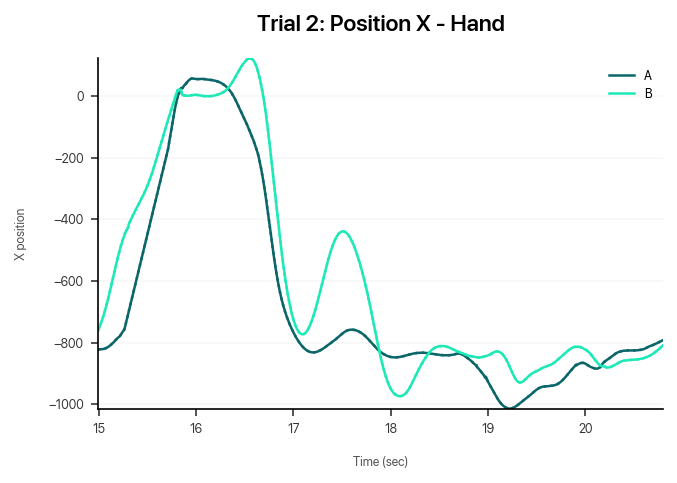

In [76]:
def plot_position(trial, marker, axis):
    plt.figure()
    for subject, subset in data[(data["Trial"] == trial) & (data["Axis"] == axis)].groupby("Subject"):
        inverter = -1 if axis == "X" and subject == "B" else 1
        plt.plot(
            subset["Time"], 
            inverter * subset[marker], 
            linewidth = 1.2, 
            label = subject, 
            color = dict(A = "C0", B = "C1")[subject]
        )
        plt.plot(
            subset["Time"], 
            inverter * subset[marker].interpolate(), 
            linewidth = 1.2, 
            linestyle = ":", 
            color = dict(A = "C0", B = "C1")[subject]
        )
    plt.margins(x = 0, y = 0)
    plt.title(f"Trial {trial}: Position {axis} - {marker}\n")
    plt.xlabel("Time (sec)")
    plt.ylabel(f"{axis} position")
    plt.legend(loc = "upper right")
    plt.tight_layout()

plot_position(trial = 2, marker = "Hand", axis = "X")
# plot_position(trial = 1, marker = "Elbow", axis = "Z")

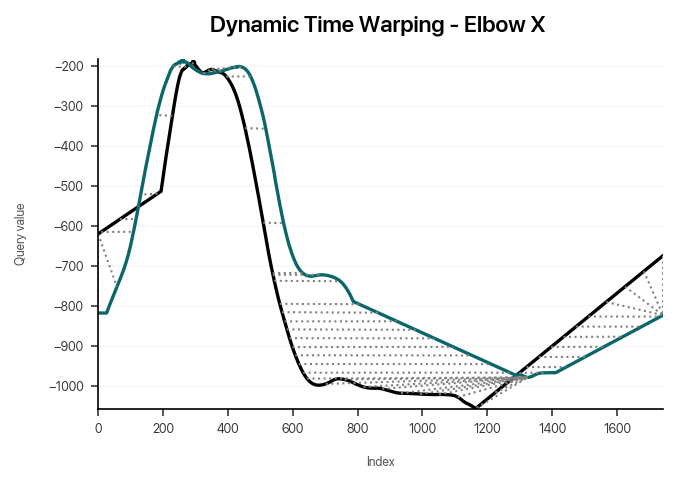

In [75]:
def plot_dtw(trial, marker, axis):
    subset = data[(data["Trial"] == trial) & (data["Axis"] == axis)].dropna(subset = marker)
    inverter = -1 if axis == "X" else 1
    data_A = subset[subset["Subject"] == "A"][marker].values
    data_B = inverter * subset[subset["Subject"] == "B"][marker].values
    dtw(data_A, data_B, keep_internals=True).plot(type = "twoway")
    plt.margins(x = 0, y = 0)
    plt.title(f"Dynamic Time Warping - {marker} {axis} \n")
    plt.tight_layout()

plot_dtw(trial = 2, marker = "Elbow", axis = "X")

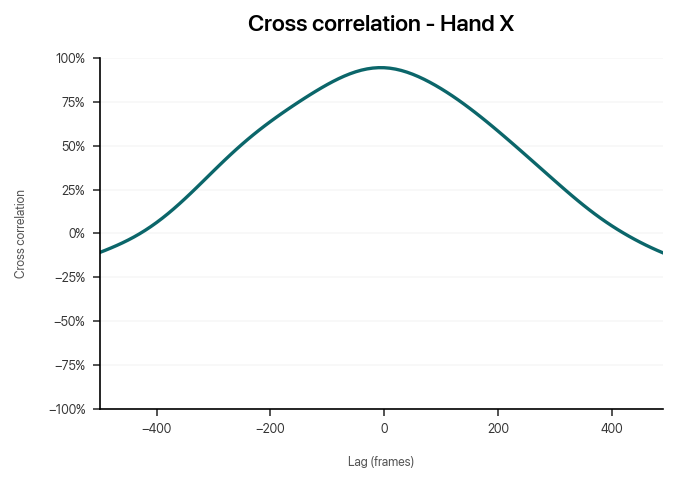

In [77]:
def plot_cross_correlation(trial, marker, axis, lags = np.arange(-500, 500, 10)):
    data_A = data[(data["Trial"] == trial) & (data["Axis"] == axis) & (data["Subject"] == "A")][marker].interpolate().reset_index(drop = True)
    data_B = data[(data["Trial"] == trial) & (data["Axis"] == axis) & (data["Subject"] == "B")][marker].interpolate().reset_index(drop = True)
    inverter = -1 if axis == "X" else 1
    cross_corrs = [data_A.corr(inverter * data_B.shift(lag)) for lag in lags]
    plt.plot(lags, cross_corrs)
    plt.xlabel("Lag (frames)")
    plt.ylabel("Cross correlation")
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.title(f"Cross correlation - {marker} {axis}\n")
    plt.margins(x = 0, y = 0.1)
    plt.ylim((-1, 1))
    plt.tight_layout()

plot_cross_correlation(trial = 1, marker = "Hand", axis = "X")

In [ ]:
# def calc_angles(data, participant, markers):
#     data.loc[:, ["dX1", "dY1", "dZ1"]] = data[[f"{participant}_{markers[0]} {axis}" for axis in "XYZ"]].values - data[[f"{participant}_{markers[1]} {axis}" for axis in "XYZ"]].values
#     data.loc[:, ["dX2", "dY2", "dZ2"]] = data[[f"{participant}_{markers[1]} {axis}" for axis in "XYZ"]].values - data[[f"{participant}_{markers[2]} {axis}" for axis in "XYZ"]].values
#     line1 = data[["dX1", "dY1", "dZ1"]].divide(np.linalg.norm(data[["dX1", "dY1", "dZ1"]].values, axis=1), axis = 0)
#     line2 = data[["dX2", "dY2", "dZ2"]].divide(np.linalg.norm(data[["dX2", "dY2", "dZ2"]].values, axis=1), axis = 0)

#     return np.degrees(np.arccos(np.clip(np.sum(line1.values * line2.values, axis = 1), -1, 1)))

# def plot_angles(markers):
#     for participant in "AB":
#         subset = data[["Time"] + [f"{participant}_{marker} {axis}" for marker in markers for axis in "XYZ"]].dropna()
#         plt.plot(subset["Time"], calc_angles(subset, participant, markers), label = participant)
#     plt.title("Elbow Angle\n")
#     plt.xlabel("Time (sec)")
#     plt.ylabel("Elbow angle (°)")
#     plt.margins(x=0)
#     plt.legend()
#     plt.tight_layout()

def calc_angles(data, participant, markers):
    line1_markers, line2_markers = markers[:-1], markers[1:]
    # data[["dX", "dY", "dZ"]] = data[["Interp_" + axis for axis in "XYZ"]].subtract(data[["Interp_" + axis for axis in "XYZ"]], axis = 0)
    # print(data)
    a = data.droplevel("Marker")
    print(a)
    print(data)

    print(a.shape, data.index.levshape)
    a[:, "Line1"] = data.loc[:, line1_markers[0]][["Interp_" + axis for axis in "XYZ"]] - data.loc[:, line1_markers[1]][["Interp_" + axis for axis in "XYZ"]]
    # a[:, "Line2"] = data.loc[:, :, line2_markers[0]][["Interp_" + axis for axis in "XYZ"]] - data.loc[:, :, line2_markers[1]][["Interp_" + axis for axis in "XYZ"]]
    print(data)
    # data[["dX", "dY", "dZ"]] = data.loc[][["Interp_" + axis for axis in "XYZ"]] - data.loc[][["Interp_" + axis for axis in "XYZ"]]
    # print(data)
    # print(data[["Interp_" + axis for axis in "XYZ"]])
    # data.loc[:, ["dX2", "dY2", "dZ2"]] = data[[f"{participant}_{markers[1]} {axis}" for axis in "XYZ"]].values - data[[f"{participant}_{markers[2]} {axis}" for axis in "XYZ"]].values
    # line1 = data[["dX1", "dY1", "dZ1"]].divide(np.linalg.norm(data[["dX1", "dY1", "dZ1"]].values, axis=1), axis = 0)
    # line2 = data[["dX2", "dY2", "dZ2"]].divide(np.linalg.norm(data[["dX2", "dY2", "dZ2"]].values, axis=1), axis = 0)

    # return np.degrees(np.arccos(np.clip(np.sum(line1.values * line2.values, axis = 1), -1, 1)))

def plot_angles(trial, markers):
    markers = list(markers)
    for participant in "AB":
        # subset = data[["Time"] + [f"{participant}_{marker} {axis}" for marker in markers for axis in "XYZ"]].dropna()
        subset = data.loc[trial, :, participant, markers].droplevel(("Trial", "Participant"))
        # print(subset)
        calc_angles(subset, participant, markers)
        # plt.plot(subset["Time"], calc_angles(subset, participant, markers), label = participant)
    plt.title("Elbow Angle\n")
    plt.xlabel("Time (sec)")
    plt.ylabel("Elbow angle (°)")
    plt.margins(x=0)
    plt.legend()
    plt.tight_layout()

plot_angles(trial = 1, markers = ("ShoulderRight", "Elbow", "Hand"))

                X        Y        Z  Interp_X  Interp_Y   Interp_Z
Time                                                              
5.29000       NaN      NaN      NaN -973.8825 -402.1165  1543.1425
5.29333       NaN      NaN      NaN -974.0445 -402.2030  1543.2340
5.29667       NaN      NaN      NaN -974.2345 -402.2870  1543.3235
5.30000       NaN      NaN      NaN -974.4245 -402.3725  1543.4060
5.30333       NaN      NaN      NaN -974.5675 -402.4500  1543.4900
...           ...      ...      ...       ...       ...        ...
14.97667 -822.995 -359.594  839.718 -822.9950 -359.5940   839.7180
14.98000 -822.772 -362.541  840.641 -822.7720 -362.5410   840.6410
14.98333 -822.574 -365.572  841.691 -822.5740 -365.5720   841.6910
14.98667 -822.426 -368.556  842.624 -822.4260 -368.5560   842.6240
14.99000 -822.267 -371.709  843.825 -822.2670 -371.7090   843.8250

[8733 rows x 6 columns]
                              X        Y        Z  Interp_X  Interp_Y  \
Time     Marker                

KeyError: 'ShoulderRight'